In [1]:
import os
from argparse import Namespace
from pathlib import Path

import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import trange

In [2]:
from dpsnn import SplitNN, ConvAttackModel, plot_images, AttackDataset
from dpsnn.utils import load_attacker, load_classifier

In [3]:
project_root = Path.cwd().resolve().parents[1]

---
# Noise during training
In this experiment,
we investigate the impact of adding laplacian noise to the intermediate tensor **during training**.
---

## Load target model
Load a model trained without noise

In [4]:
classifiers_path = project_root / "models" / "classifiers"
os.listdir(classifiers_path)

['mnist_05noise_005nopeek_epoch=04.ckpt',
 'mnist_02noise_00nopeek_epoch=07.ckpt',
 'mnist_05noise_025nopeek_epoch=09.ckpt',
 'mnist_10noise_00nopeek_epoch=08.ckpt',
 'mnist_10noise_05nopeek_epoch=08.ckpt',
 'mnist_10noise_01nopeek_epoch=08.ckpt',
 'mnist_10noise_025nopeek_epoch=08.ckpt',
 'mnist_02noise_05nopeek_epoch=06.ckpt',
 'mnist_01noise_00nopeek_epoch=06.ckpt',
 'mnist_05noise_00nopeek_epoch=08.ckpt',
 'mnist_00noise_00nopeek_epoch=06.ckpt',
 'mnist_01noise_05nopeek_epoch=09.ckpt',
 'mnist_05noise_05nopeek_epoch=07.ckpt',
 'mnist_01noise_01nopeek_epoch=09.ckpt',
 'mnist_00noise_01nopeek_epoch=09.ckpt',
 'mnist_00noise_10nopeek_epoch=09.ckpt',
 '.gitkeep',
 'mnist_05noise_01nopeek_epoch=08.ckpt',
 'mnist_02noise_025nopeek_epoch=08.ckpt',
 'mnist_00noise_05nopeek_epoch=08.ckpt',
 'mnist_01noise_025nopeek_epoch=06.ckpt',
 'mnist_02noise_01nopeek_epoch=08.ckpt']

In [6]:
target_model00_00 = load_classifier(classifiers_path / "mnist_00noise_00nopeek_epoch=06.ckpt")

target_model01_01 = load_classifier(classifiers_path / "mnist_01noise_01nopeek_epoch=09.ckpt")
target_model01_025 = load_classifier(classifiers_path / "mnist_01noise_025nopeek_epoch=06.ckpt")
target_model01_05 = load_classifier(classifiers_path / "mnist_01noise_05nopeek_epoch=09.ckpt")


target_model02_01 = load_classifier(classifiers_path / "mnist_02noise_01nopeek_epoch=08.ckpt")
target_model02_025 = load_classifier(classifiers_path / "mnist_02noise_025nopeek_epoch=08.ckpt")
target_model02_05 = load_classifier(classifiers_path / "mnist_02noise_05nopeek_epoch=06.ckpt")

target_model05_01 = load_classifier(classifiers_path / "mnist_05noise_01nopeek_epoch=08.ckpt")
target_model05_025 = load_classifier(classifiers_path / "mnist_05noise_025nopeek_epoch=09.ckpt")
target_model05_05 = load_classifier(classifiers_path / "mnist_05noise_05nopeek_epoch=07.ckpt")

target_models_01_x = [target_model01_01, target_model01_025, target_model01_05]
target_models_02_x = [target_model02_01, target_model02_025, target_model02_05]
target_models_05_x = [target_model05_01, target_model05_025, target_model05_05]
target_models = [target_model01_01, target_model01_025, target_model01_05, target_model02_01, target_model02_025, target_model02_05]

---
# Attack models

## Get validation set for attackers

- Classifier is trained on first `40'000` MNIST "train" images
- Attacker is trained on `40'000-45'000` first MNIST "train" images
- Validate attacker on MNIST "train" images `45'000-50'000`

In [7]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # PyTorch examples; https://github.com/pytorch/examples/blob/master/mnist/main.py
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

attack_val_dataset = torch.utils.data.Subset(
        MNIST(project_root / "data", download=True, train=True, transform=transform),
        range(45_000, 50_000),
)

## Load attackers

In [8]:
attackers_dir = project_root / "models" / "attackers"
os.listdir(attackers_dir)

['mnist_attacker_model<mnist_01noise_025nopeek>.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set01noise.ckpt',
 'mnist_attacker_model<mnist_02noise_01nopeek>.ckpt',
 'mnist_attacker_model<mnist_00noise_01nopeek.ckpt',
 'mnist_attacker_model<mnist_05noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_05nopeek.ckpt',
 'mnist_attacker_model<mnist_10noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set05noise.ckpt',
 'mnist_attacker_model<mnist_02noise_05nopeek>.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_05noise_005nopeek>.ckpt',
 'mnist_attacker_model<mnist_01noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek>_set10noise.ckpt',
 '.gitkeep',
 'mnist_attacker_model<mnist_01noise_05nopeek>.ckpt',
 'mnist_attacker_model<mnist_00noise_10nopeek.ckpt',
 'mnist_attacker_model<mnist_01noise_01nopeek>.ckpt',
 'mnist_attacker_model<mnist_05noise_05nopeek>.ckpt',
 'mnist_attacker_model<mnist_02noise_025n

In [9]:
attack_model01_01 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_01noise_01nopeek>.ckpt")
attack_model01_025 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_01noise_025nopeek>.ckpt")
attack_model01_05 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_01noise_05nopeek>.ckpt")

attack_model02_01 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_02noise_01nopeek>.ckpt")
attack_model02_025 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_02noise_025nopeek>.ckpt")
attack_model02_05 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_02noise_05nopeek>.ckpt")

attack_model05_01 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_05noise_01nopeek>.ckpt")
attack_model05_025 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_05noise_025nopeek>.ckpt")
attack_model05_05 = load_attacker(attackers_dir / "mnist_attacker_model<mnist_05noise_05nopeek>.ckpt")

attack_models_01_x = [attack_model01_01, attack_model01_025, attack_model01_05]
attack_models_02_x = [attack_model02_01, attack_model02_025, attack_model02_05]
attack_models_05_x = [attack_model05_01, attack_model05_025, attack_model05_05]
attack_models = [attack_model01_01, attack_model01_025, attack_model01_05, attack_model02_01, attack_model02_025, attack_model02_05]

## Visualise reconstruction

### 0.1 noise

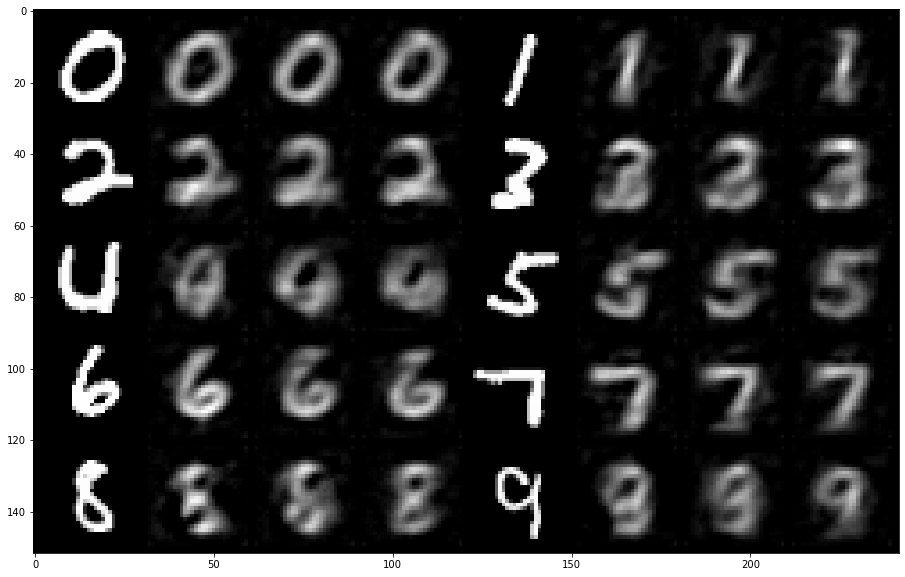

In [10]:
ims = []

label_to_plot = 0
idx = 10

while True:
    image, im_label = attack_val_dataset[idx]
    idx += 1

    if im_label != label_to_plot:
        continue
        
    ims.append(image)

    for target_model, attack_model in zip(target_models_01_x, attack_models_01_x):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

    label_to_plot += 1
    if label_to_plot == 10:
        break

plot_images(ims, rows=8)#, savepath=project_root / "results" / "figures" / "mnist_laplacian_dp_01_and_nopeek_attack.png")

### 0.2 noise

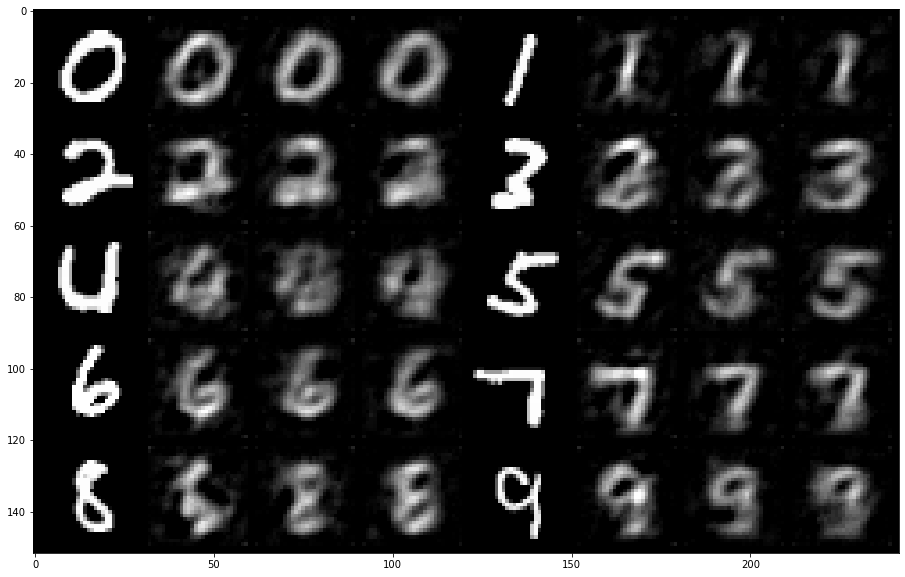

In [11]:
ims = []

label_to_plot = 0
idx = 10

while True:
    image, im_label = attack_val_dataset[idx]
    idx += 1

    if im_label != label_to_plot:
        continue
        
    ims.append(image)

    for target_model, attack_model in zip(target_models_02_x, attack_models_02_x):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

    label_to_plot += 1
    if label_to_plot == 10:
        break

plot_images(ims, rows=8)#, savepath=project_root / "results" / "figures" / "mnist_laplacian_dp_02_and_nopeek_attack.png")

### 0.5 Noise

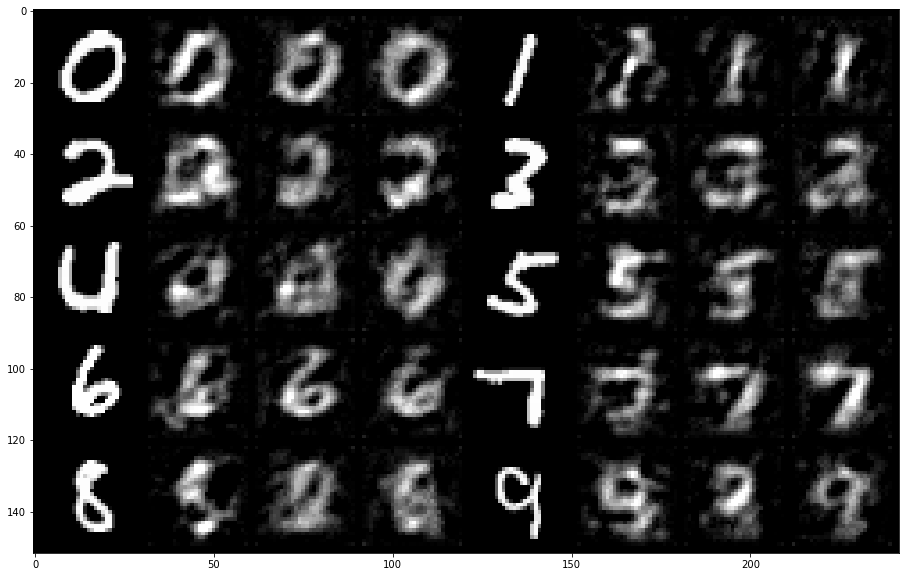

In [14]:
ims = []

label_to_plot = 0
idx = 10

while True:
    image, im_label = attack_val_dataset[idx]
    idx += 1

    if im_label != label_to_plot:
        continue
        
    ims.append(image)

    for target_model, attack_model in zip(target_models_05_x, attack_models_05_x):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

    label_to_plot += 1
    if label_to_plot == 10:
        break

plot_images(ims, rows=8)#, savepath=project_root / "results" / "figures" / "mnist_laplacian_dp_05_and_nopeek_attack.png")

### All models

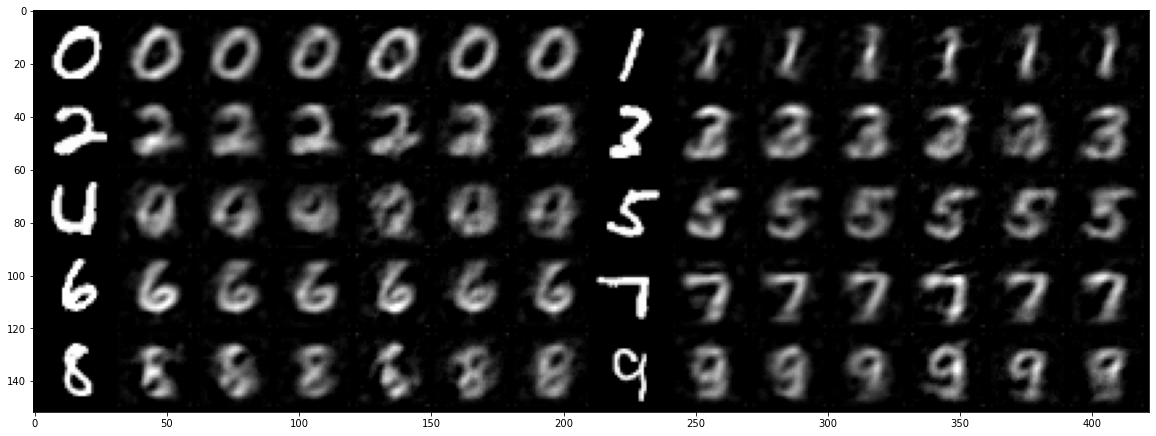

In [12]:
ims = []

label_to_plot = 0
idx = 10

while True:
    image, im_label = attack_val_dataset[idx]
    idx += 1

    if im_label != label_to_plot:
        continue
        
    ims.append(image)

    for target_model, attack_model in zip(target_models, attack_models):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

    label_to_plot += 1
    if label_to_plot == 10:
        break

plot_images(ims, rows=14)#, savepath=project_root / "results" / "figures" / "mnist_laplacian_dp_and_nopeek_attack.png")